<a href="https://colab.research.google.com/github/scapolingua/darknet/blob/master/Encoding_4_ClusterImg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip3 install face_recognition

     |████████████████████████████████| 100.2MB 42kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=8dc856b2f2457d4b5d32baebf97972537a54599707ca4f45feb31e9cb9465bf9
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [ ]:
# import the necessary packages
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os

# construct the argument parser and parse the arguments
dataset='/content/4Clustering'
fileenc='encodings.pickle'
method="cnn"


# grab the paths to the input images in our dataset, then initialize
# out data list (which we'll soon populate)
print("[INFO] quantifying faces...")
imagePaths = list(paths.list_images(dataset))
data = []

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
  # load the input image and convert it from RGB (OpenCV ordering)
  # to dlib ordering (RGB)
  print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
  print(imagePath)
  image = cv2.imread(imagePath)
  rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # detect the (x, y)-coordinates of the bounding boxes
  # corresponding to each face in the input image
  boxes = face_recognition.face_locations(rgb,model=method)
  # compute the facial embedding for the face
  encodings = face_recognition.face_encodings(rgb,boxes)
  # build a dictionary of the image path, bounding box location,
  # and facial encodings for the current image
  d = [{"imagePath": imagePath, "loc": box, "encoding": enc}
       for (box, enc) in zip(boxes, encodings)]
  data.extend(d)

# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open(fileenc, "wb")
f.write(pickle.dumps(data)) 
f.close()


[INFO] loading encodings...
[INFO] clustering...
[INFO] # unique faces: 2
[INFO] faces for face ID: -1


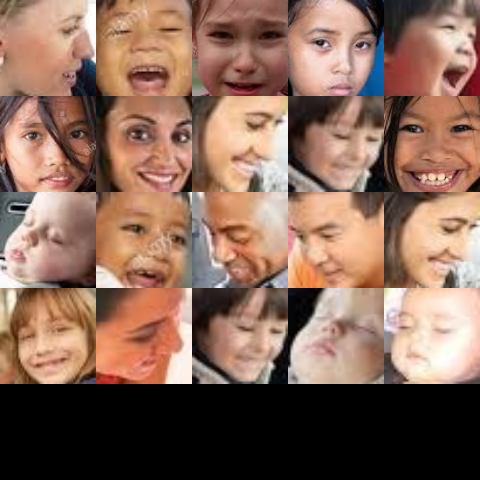

[INFO] faces for face ID: 0


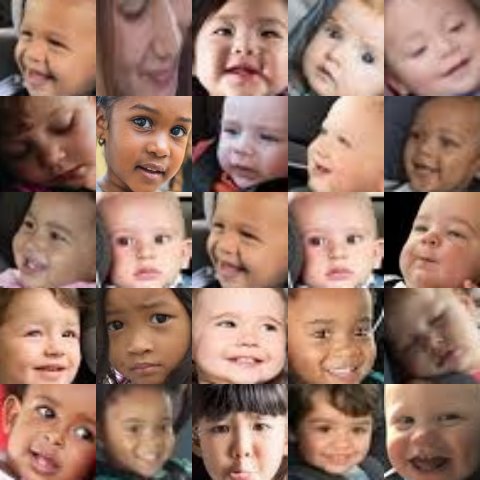

[INFO] faces for face ID: 1


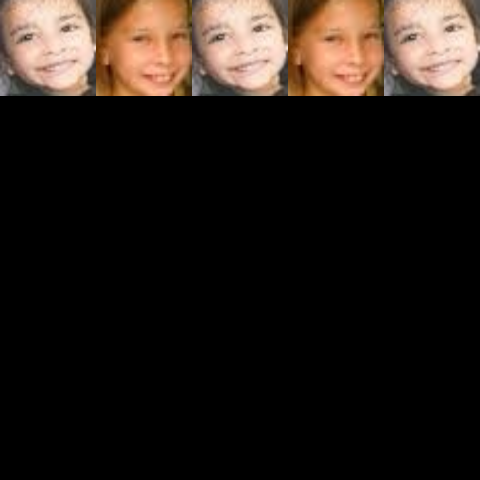

In [79]:
# import the necessary packages
from sklearn.cluster import DBSCAN
from imutils import build_montages
import numpy as np
import argparse
import pickle
import cv2
from google.colab.patches import cv2_imshow

encodings='/content/encodings.pickle'
jobs=-1

# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
data = pickle.loads(open(encodings, "rb").read())
data = np.array(data)
encodings = [d["encoding"] for d in data]
# cluster the embeddings
print("[INFO] clustering...")
clt = DBSCAN(metric="euclidean", n_jobs=jobs)
clt.fit(encodings)
# determine the total number of unique faces found in the dataset
labelIDs = np.unique(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] # unique faces: {}".format(numUniqueFaces))
# loop over the unique face integers
for labelID in labelIDs:
	# find all indexes into the `data` array that belong to the
	# current label ID, then randomly sample a maximum of 25 indexes
	# from the set
	print("[INFO] faces for face ID: {}".format(labelID))
	idxs = np.where(clt.labels_ == labelID)[0]
	idxs = np.random.choice(idxs, size=min(25, len(idxs)),
		replace=False)
	# initialize the list of faces to include in the montage
	faces = []
	# loop over the sampled indexes
	for i in idxs:
		# load the input image and extract the face ROI
		image = cv2.imread(data[i]["imagePath"])
		(top, right, bottom, left) = data[i]["loc"]
		face = image[top:bottom, left:right]
		# force resize the face ROI to 96x96 and then add it to the
		# faces montage list
		face = cv2.resize(face, (96, 96))
		faces.append(face)
	# create a montage using 96x96 "tiles" with 5 rows and 5 columns
	montage = build_montages(faces, (96, 96), (5, 5))[0]
	
	# show the output montage
	title = "Face ID #{}".format(labelID)
	title = "Unknown Faces" if labelID == -1 else title
	cv2_imshow(montage)
	cv2.waitKey(0)

In [71]:
%tb

SystemExit: ignored